In [402]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
import pickle
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
# Load dataset
df0 = pd.read_csv('HR_capstone_dataset.csv')

# Make a copy

df = df0.copy()

df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

# 1. Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


14999 entries with all columns having 14999 non null values = no NaN values

In [5]:
# Check for duplicate values

df.duplicated().sum()

np.int64(3008)

We have 3008 duplicated

In [6]:
# drop duplicates
df1 = df.drop_duplicates()

df1.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [7]:
# Rename columns
df1 = df1.rename(columns = {
    'average_montly_hours' : 'average_monthly_hours',
    'time_spend_company' : 'tenure',
    'Work_accident' : 'work_accident',
    'Department': 'department',
    
})


In [8]:
df1.describe()

satisfaction_level  last_evaluation  number_project  \
count        11991.000000     11991.000000    11991.000000   
mean             0.629658         0.716683        3.802852   
std              0.241070         0.168343        1.163238   
min              0.090000         0.360000        2.000000   
25%              0.480000         0.570000        3.000000   
50%              0.660000         0.720000        4.000000   
75%              0.820000         0.860000        5.000000   
max              1.000000         1.000000        7.000000   

       average_monthly_hours        tenure  work_accident          left  \
count           11991.000000  11991.000000   11991.000000  11991.000000   
mean              200.473522      3.364857       0.154282      0.166041   
std                48.727813      1.330240       0.361234      0.372133   
min                96.000000      2.000000       0.000000      0.000000   
25%               157.000000      3.000000       0.000000      0.000000   
50%               200.000000      3.000000       0.000000      0.000000   
75%               243.000000      4.000000       0.000000      0.000000   
max               310.000000     10.000000       1.000000      1.000000   

       promotion_last_5years  
count           11991.000000  
mean                0.016929  
std                 0.129012  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

#### Look for outliers

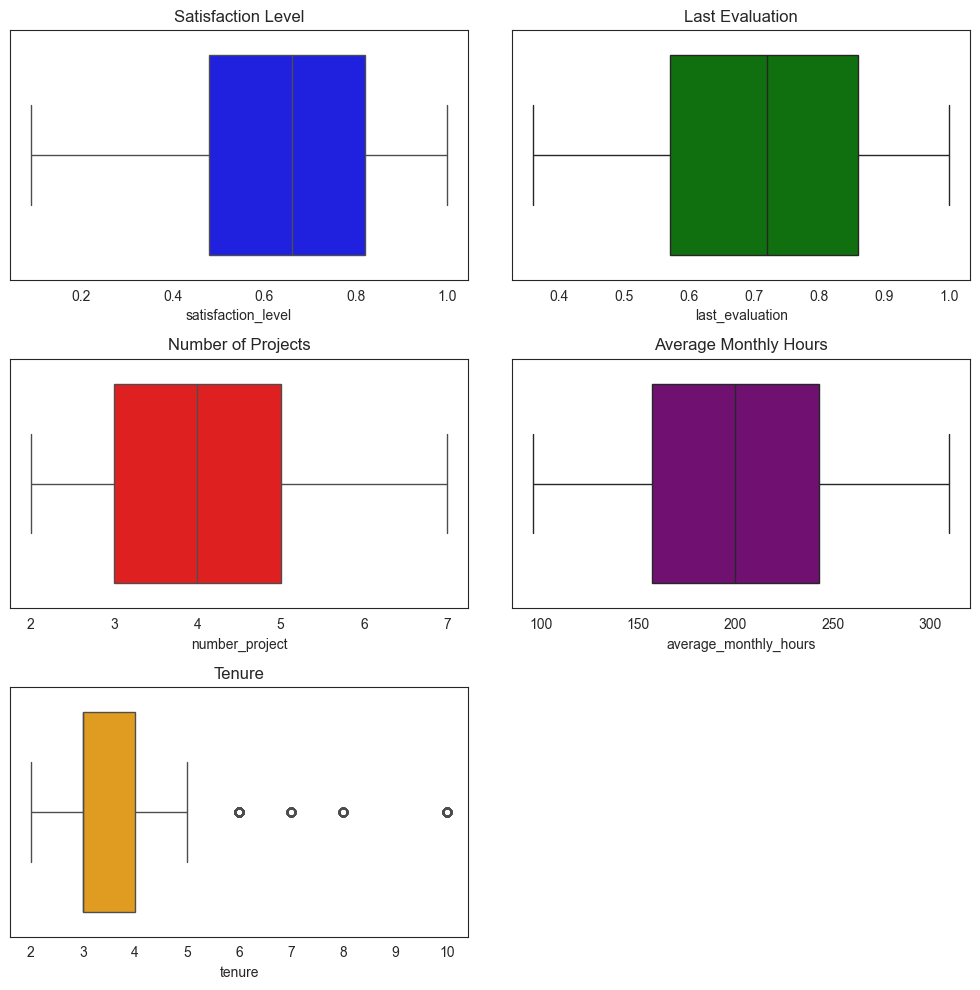

In [397]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plotting boxplots for each variable
sns.boxplot(x=df1['satisfaction_level'], ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Satisfaction Level')

sns.boxplot(x=df1['last_evaluation'], ax=axs[0, 1], color='green')
axs[0, 1].set_title('Last Evaluation')

sns.boxplot(x=df1['number_project'], ax=axs[1, 0], color='red')
axs[1, 0].set_title('Number of Projects')

sns.boxplot(x=df1['average_monthly_hours'], ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Average Monthly Hours')

sns.boxplot(x=df1['tenure'], ax=axs[2, 0], color='orange')
axs[2, 0].set_title('Tenure')

plt.tight_layout()
fig.delaxes(axs[2,1])
plt.show()

Only outliers for tenure, but these are reasonable and not seen as anomolies, so we will keep this data

# 2. EDA

We want to investigate how many people left and stayed, and any factors that may contribute to this.

In [11]:
left_count = df1['left'].value_counts()
print(left_count)

left_percentage = df1['left'].value_counts(normalize = True) * 100
print(left_percentage)

left
0    10000
1     1991
Name: count, dtype: int64
left
0    83.39588
1    16.60412
Name: proportion, dtype: float64


- From 10000 employees, 1991 left the company
- This is 16.6% of total employees that left and 83.4% staying

Now we will look the relationship between our variables and if workers stayed or left

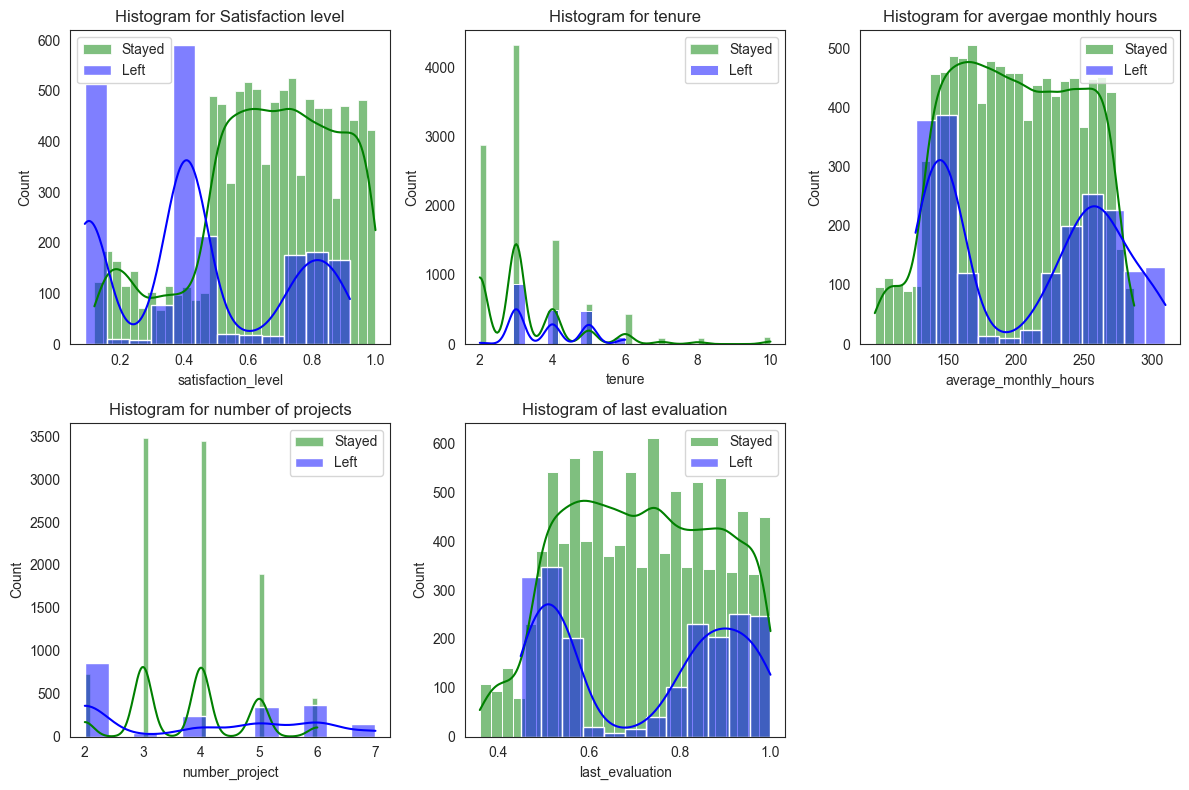

In [39]:
# Form overalpping histograms

plt.figure(figsize = (12,8))

# Satisfaction level
plt.subplot(2,3,1)
sns.histplot(df1[df1['left'] == 0]['satisfaction_level'], kde = True, color = 'green', label = 'Stayed')
sns.histplot(df1[df1['left'] == 1]['satisfaction_level'], kde = True, color = 'blue', label = 'Left')
plt.title("Histogram for Satisfaction level")
plt.legend()

# Tenure
plt.subplot(2, 3, 2)
sns.histplot(df1[df1['left'] == 0]['tenure'], kde=True, color='green', label='Stayed')
sns.histplot(df1[df1['left'] == 1]['tenure'], kde=True, color='blue', label='Left')
plt.title("Histogram for tenure")
plt.legend()

# Average Monthly hours
plt.subplot(2, 3, 3)
sns.histplot(df1[df1['left'] == 0]['average_monthly_hours'], kde=True, color='green', label='Stayed')
sns.histplot(df1[df1['left'] == 1]['average_monthly_hours'], kde=True, color='blue', label='Left')
plt.title("Histogram for avergae monthly hours")
plt.legend()

# number_project
plt.subplot(2, 3, 4)
sns.histplot(df1[df1['left'] == 0]['number_project'], kde=True, color='green', label='Stayed')
sns.histplot(df1[df1['left'] == 1]['number_project'], kde=True, color='blue', label='Left')
plt.title("Histogram for number of projects")
plt.legend()

# last_evaluation
plt.subplot(2, 3, 5)
sns.histplot(df1[df1['left'] == 0]['last_evaluation'], kde=True, color='green', label='Stayed')
sns.histplot(df1[df1['left'] == 1]['last_evaluation'], kde=True, color='blue', label='Left')
plt.title("Histogram of last evaluation")
plt.legend()

plt.subplot(2, 3, 6)
sns.histplot(df1[df1['left'] == 0]['number_project'], kde=True, color='green', label='Stayed')
sns.histplot(df1[df1['left'] == 1]['last_evaluation'], kde=True, color='blue', label='Left')
plt.title("Histogram of last evaluation")
plt.legend()

plt.tight_layout()
plt.show()

From this we can see 4 variables that can be further explored
- Satisfaction level 
- Average monthly hours
- Last evaluation
- Number of projects

1. Satisfaction Level
- Distribution: The histogram shows a higher frequency of employees who left at lower satisfaction levels.
- The density line indicates that employees with lower satisfaction levels are more likely to leave.



2. Last Evaluation
- Distribution: The histogram shows a fairly even distribution, with slight peaks for those who left around the high and low extremes.
- The density line suggests that employees with very high or very low evaluations are more likely to leave.

3. Average Monthly Hours
- Distribution: There are two peaks in the frequency of employees leaving, one at the lower end and one at the higher end of hours worked.
-  The density line indicates that both underworked and overworked employees are more likely to leave.

- At around 300 weekly hours, every employee has left

4. Number of projects
 - We can see at 7 projects, every employee leaves

Key Observations
- Satisfaction Level: Lower satisfaction levels are strongly correlated with higher turnover rates. Improving job satisfaction could help reduce turnover.
- Performance Evaluations: Employees with extreme evaluation scores (very high or very low) are more likely to leave. This could indicate issues with performance management or recognition.
- Workload: Both underworked and overworked employees are more likely to leave. Ensuring a balanced workload is crucial.

**Go into these 4 variables further**

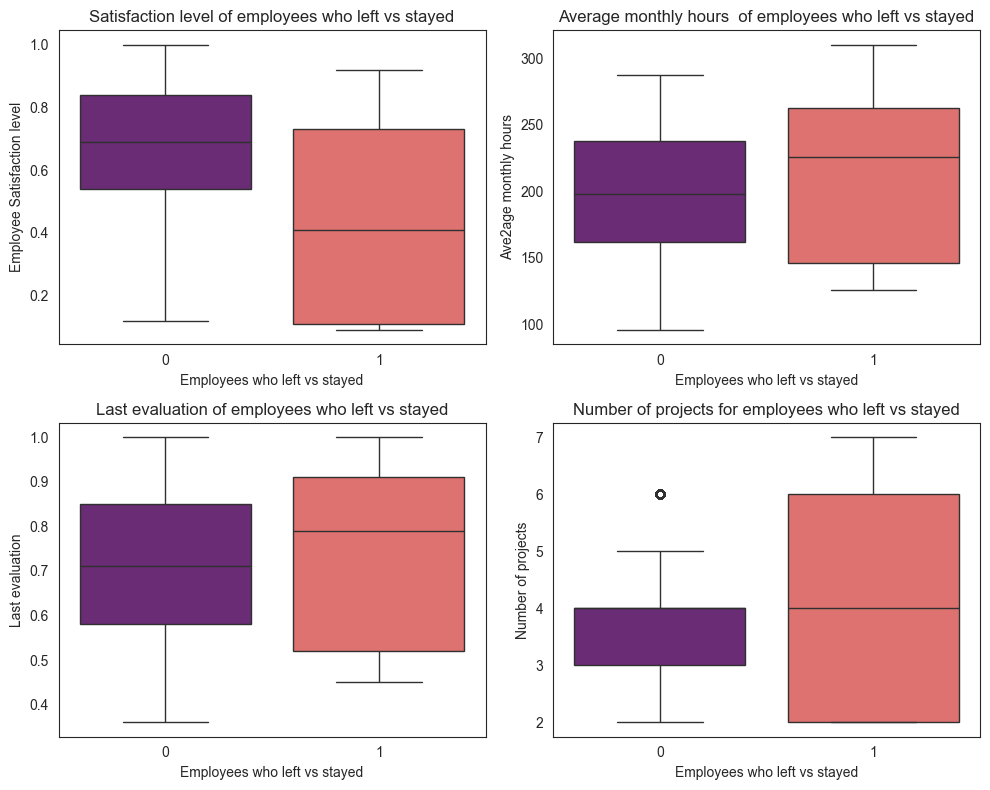

In [381]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
sns.boxplot(x='left', y='satisfaction_level', data=df1, palette="magma")
plt.xlabel("Employees who left vs stayed")
plt.ylabel("Employee Satisfaction level")
plt.title("Satisfaction level of employees who left vs stayed")

plt.subplot(2, 2, 2)
sns.boxplot(x='left', y='average_monthly_hours', data=df1, palette="magma")
plt.xlabel("Employees who left vs stayed")
plt.ylabel("Ave2age monthly hours")
plt.title("Average monthly hours  of employees who left vs stayed")

plt.subplot(2, 2, 3)
sns.boxplot(x='left', y='last_evaluation', data=df1, palette="magma")
plt.xlabel("Employees who left vs stayed")
plt.ylabel("Last evaluation")
plt.title("Last evaluation of employees who left vs stayed")

plt.subplot(2, 2, 4)
sns.boxplot(x='left', y='number_project', data=df1, palette="magma")
plt.xlabel("Employees who left vs stayed")
plt.ylabel("Number of projects")
plt.title("Number of projects for employees who left vs stayed")

plt.tight_layout() 
plt.show()

Satisfaction Level of Employees Who Left vs Stayed:
- Lower Satisfaction Among Leavers: The median satisfaction level for employees who left is noticeably lower than for those who stayed. This suggests that dissatisfaction could be a significant factor in employee turnover.




Average Monthly Hours of Employees Who Left vs Stayed
- Higher Workload for Leavers: Employees who left generally worked more hours per month compared to those who stayed. The higher median and upper quartile values for leavers suggest that overwork might be a contributing factor to their decision to leave.

Last Evaluation of Employees Who Left vs Stayed
- Slightly Lower Evaluations for Leavers: The median last evaluation score for employees who left is slightly lower than for those who stayed. This might indicate that employees who left were not performing as well or were not perceived as performing as well

Number of Projects for Employees Who Left vs. Stayed
- Employees who left were involved in more projects on average. The box plot shows a higher median and a wider IQR for the number of projects handled by those who left.

**We can now anaylis categorical variable, and how they affect if someone leaves or stay**
- salary
- form bins from last evaluation score (low, meium, high)
- promotion last 5 years

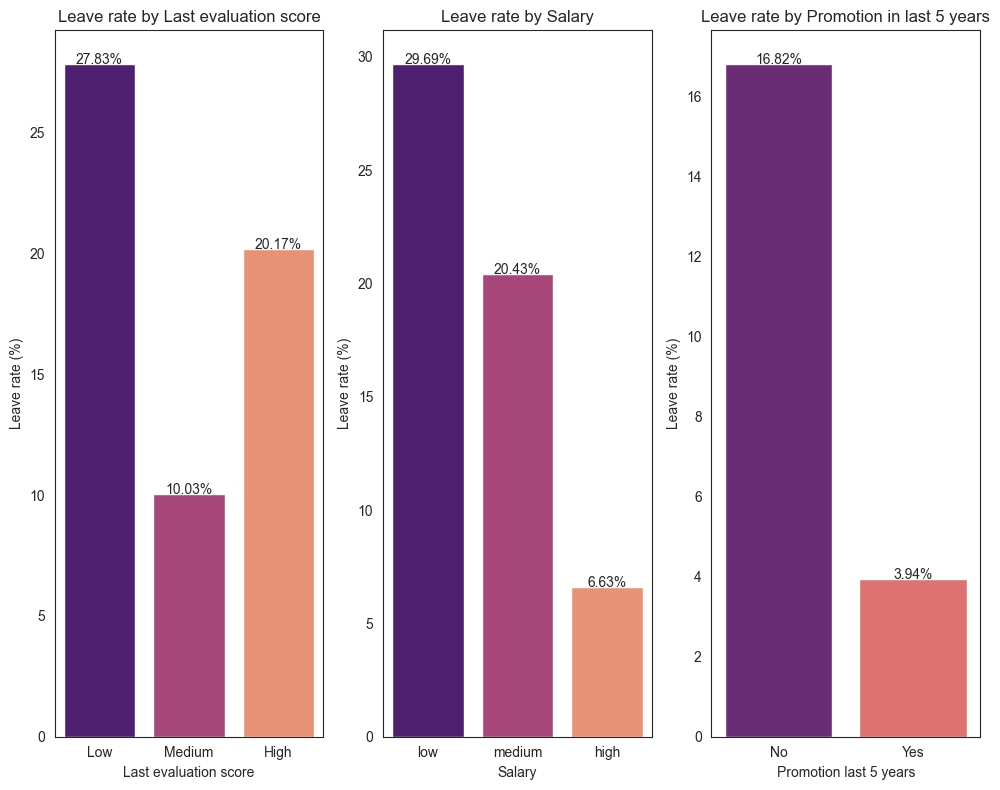

In [382]:
# Create bin for evaluation score
bins = pd.cut(df1['last_evaluation'], bins = [0, 0.5, 0.75,1], labels = ['Low', 'Medium', 'High'])

# Find leave rate by last evaluation category
leave_rate = df1.groupby(bins)['left'].mean() * 100

plt.figure(figsize = (10,8))

plt.subplot(1,3,1)
sns.barplot(x = leave_rate.index, y = leave_rate.values, palette = 'magma')
plt.xlabel('Last evaluation score')
plt.ylabel('Leave rate (%)')
plt.title('Leave rate by Last evaluation score')

for i, value in enumerate(leave_rate.values):
    plt.text(i, value, f'{value:.2f}%', ha = 'center')

# Calculate leave rate by salary category
leave_rate_sal = df.groupby('salary')['left'].mean() * 100  

plt.subplot(1, 3, 2)
sns.barplot(x = leave_rate_sal.index ,  y = leave_rate_sal.values , palette = 'magma')
plt.xlabel('Salary')
plt.ylabel('Leave rate (%)')
plt.title('Leave rate by Salary')

# Add percentage labels
for i, value in enumerate(leave_rate_sal.values):
    plt.text(i, value, f'{value:.2f}%', ha = 'center')


#Create a bin for promotion in last 5 years
bins = pd.cut(df1['promotion_last_5years'], bins=[-0.5, 0.5, 1.5], labels=['No', 'Yes'])
leave_rate_prom = df1.groupby(bins)['left'].mean() * 100


plt.subplot(1,3,3)
sns.barplot(x = leave_rate_prom.index, y = leave_rate_prom.values, palette = 'magma')
plt.xlabel('Promotion last 5 years')
plt.ylabel('Leave rate (%)')
plt.title('Leave rate by Promotion in last 5 years')

# Add percentage labels
for i, value in enumerate(leave_rate_prom.values):
    plt.text(i, value, f'{value:.2f}%', ha = 'center')


plt.tight_layout() 
plt.show()


- Performance Evaluations: Employees with low evaluation scores are more likely to leave. However there is still a large number of employees leaving even with high evalation scores


- Salary: Salaries play a large role in an employees leave rate. We can see large differences in leaving rate from low salary indivuals to high salary indivuals.


- Promotions: Similary for promotions, there is a large difference in leave rate between indivuals who have got a promotion in the last 5 years.

Therefore from the anaylsis above, we can say Salary, Employee Satisfaction , Average mounthly hours, promotion in last 5 years show the most signifance difference among  factors in if an employee leaves the company or not

**Look at correlation between these variables now**

In [142]:
fig = px.scatter(df1, x = "satisfaction_level", y = "average_monthly_hours",
                 opacity = 0.3,
                 color = 'left')

fig.update_layout(template = "plotly_dark")

fig.show()


We can see it forms 3 main clusters

- one on the top left (very high hours and very low satisfaction rates)

- middle bottom left (working less hours and medium satisfaction)

- near the top right (these have high satisfaction and decently high monthly hours), this cluster can be due to a 3rd factor, such as salary, number of projects, last evaluation, ect.

In [141]:
fig = px.scatter_3d(df1, x = "satisfaction_level", y = "average_monthly_hours", z = "last_evaluation",
                 opacity = 0.1,
                 color = 'left')

fig.update_traces(marker = dict(size = 3.5)) # scaling down the markers
fig.update_layout(template = "plotly_dark")

fig.show()


- 2/3 of the large clusters are clusters with high last_evlations, so maybe last evaluation doesnt play a large factor when deciding if a indivual will leave or not, lets look at number of projects now ,

- Furthermore again we can see the strong correlation between working the most hours and having the lowest satisfaction score, no matter the last evaluation


In [131]:
fig = px.scatter_3d(df1, x = "satisfaction_level", y = "average_monthly_hours", z = "number_project",
                 opacity = 0.15,
                 color = 'left')

fig.update_traces(marker = dict(size = 3.5)) # scaling down the markers
fig.update_layout(template = "plotly_dark")

fig.show()

Here we can see the strong clusters form at the lowest satisfaction, around 300 hours worked and the 6,7 projects.

Showing the extremes of these factors may play a large role in an employee leaving.

In [138]:
fig = px.scatter_3d(df1, x = "satisfaction_level", y = "number_project", z = "salary",
                 opacity = 0.15,
                 color = 'left')

fig.update_traces(marker = dict(size = 3.5)) # scaling down the markers
fig.update_layout(template = "plotly_dark")

fig.show()

From here we can see the strongest clusters form at 5,6,7 projects at low satisfaction levels.

However we can see stronger clusters form at low and medium at the same satisfaction level and number of projects compared to high salary. Hence the higher salary may offset the low satisfaction and number of projects, leading to less people from higher salaries leaving.

In [393]:
fig = px.scatter_3d(df1, x = "average_monthly_hours", y = "number_project", z = "salary",
                 opacity = 1,
                 color = 'left')

fig.update_traces(marker = dict(size = 3.5)) # scaling down the markers
fig.update_layout(template = "plotly_dark")

This high pay tradeoff can be further shown here:

- Employees leaving are clustered heavily at low salaries in all number of projects (2-7) at the extremes of monthly hours.  With the amount employees leaving increasing per project, until at 7 projects every employee no matter the hours has left.

- For medium salary, there are less clusters at the extremes of monthly hours and low number of projects. But again it  increases per project until at 7 projects, every employee has left no matter the hours worked.

- Then for a high salary, a cluster only form at 6 projects with again every employee at 7 projects leaving.




In [146]:
fig = px.scatter(df1, x = "number_project", y = "average_monthly_hours",
                 opacity = 0.3,
                 color = 'left')

fig.update_layout(template = "plotly_dark")

fig.show()


- At 7 number of projects all employees leave,

- Bigger clusters form at higher monthly hours as each number of project increases

In [394]:
fig = px.scatter_3d(df1, x = "average_monthly_hours", y = "satisfaction_level", z = "number_project",
                 opacity = 0.5,
                 color = 'left')

fig.update_traces(marker = dict(size = 3.5)) # scaling down the markers
fig.update_layout(template = "plotly_dark")

**Hence from this we can say satisfaction , number of projects and average monthly hours are the key features in determing whether a employee leaves or stays**

- The 3D plots can be summarised below by the pairplots

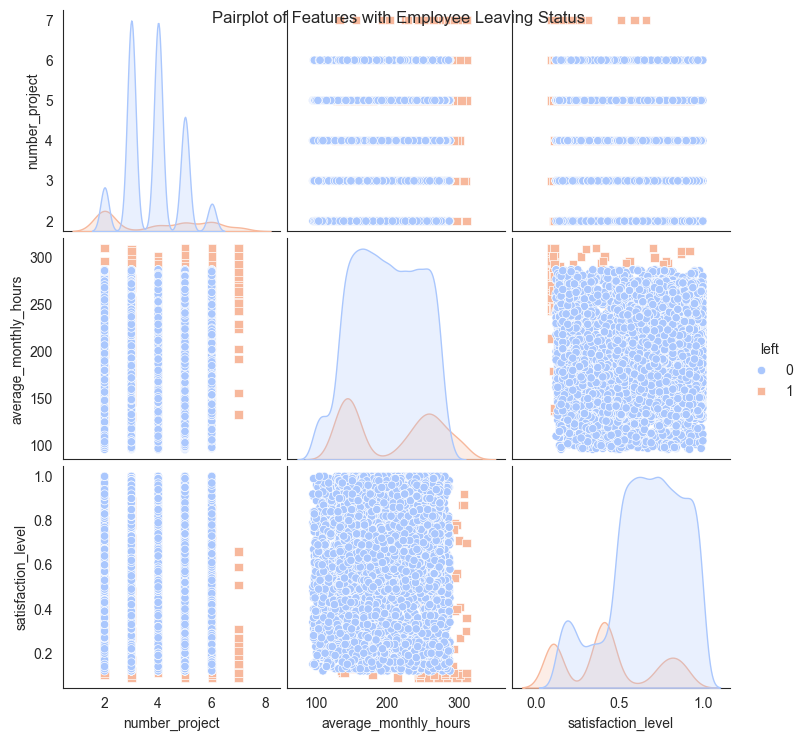

In [157]:
cols = ['number_project', 'average_monthly_hours', 'satisfaction_level', 'left']

# Pairplot with hue based on 'left'
sns.pairplot(df1[cols], hue='left', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pairplot of Features with Employee Leaving Status')
plt.show()

Through a violin plot we can view the distributions for employees who left and stayed, based on our key variables we have chosen

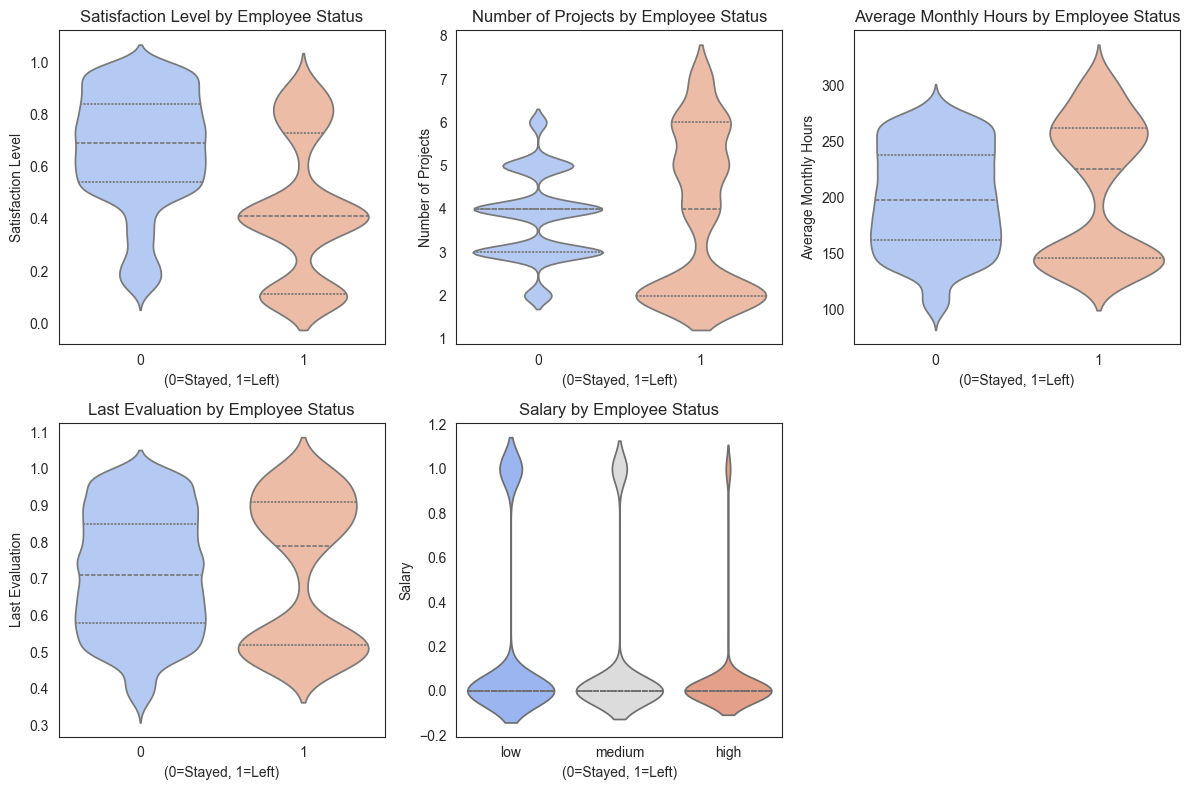

In [383]:
plt.figure(figsize = (12,8))

# Satisfaction Level Violin Plot
plt.subplot(2, 3, 1)
sns.violinplot(x='left', y='satisfaction_level', data=df1, inner = 'quartile', palette='coolwarm')
plt.title('Satisfaction Level by Employee Status')
plt.xlabel('(0=Stayed, 1=Left)')
plt.ylabel('Satisfaction Level')

# Number of Projects Violin Plot
plt.subplot(2, 3, 2)
sns.violinplot(x='left', y='number_project', data=df1, inner = 'quartile',  palette='coolwarm')
plt.title('Number of Projects by Employee Status')
plt.xlabel('(0=Stayed, 1=Left)')
plt.ylabel('Number of Projects')

# Average Monthly Hours Violin Plot
plt.subplot(2, 3, 3)
sns.violinplot(x='left', y='average_monthly_hours', data=df1, inner = 'quartile' , palette='coolwarm')
plt.title('Average Monthly Hours by Employee Status')
plt.xlabel('(0=Stayed, 1=Left)')
plt.ylabel('Average Monthly Hours')

# Last Evaluation Violin Plot
plt.subplot(2, 3, 4)
sns.violinplot(x='left', y='last_evaluation', data=df1, inner = 'quartile', palette='coolwarm')
plt.title('Last Evaluation by Employee Status')
plt.xlabel('(0=Stayed, 1=Left)')
plt.ylabel('Last Evaluation')

# Salary Violin Plot
plt.subplot(2, 3, 5)
sns.violinplot(x='salary', y='left', data=df1, inner = 'quartile', palette='coolwarm')
plt.title('Salary by Employee Status')
plt.xlabel('(0=Stayed, 1=Left)')
plt.ylabel('Salary')

plt.tight_layout()
plt.show()

Satisfaction Level by Employee Status:
- The distribution for employees who stayed (0) is much wider and more spread out across the satisfaction levels, with a notable concentration around the higher satisfaction levels (0.6 to 1.0).
- Employees who left (1) show a much tighter and skewed distribution towards lower satisfaction levels. This suggests that lower satisfaction levels are strongly associated with employees leaving the company.
-  Employee satisfaction is a crucial factor in retention. Higher satisfaction correlates with employees staying, while lower satisfaction is associated with a higher likelihood of leaving.


Number of Projects by Employee Status:
- Employees who stayed have a distribution concentrated around 2 to 4 projects, while those who left show a bimodal distribution, with peaks around 2 projects and 6 to 7 projects.
- This indicates that employees who are either underworked (few projects) or overwhelmed (many projects) are more likely to leave. The middle ground, around 3 to 4 projects, is where employees are more likely to stay.
- Both too few and too many projects can contribute to employee turnover. Maintaining an optimal workload might help in reducing attrition rates.

Average Monthly Hours by Employee Status:
- The distribution for employees who stayed is more uniform and centered around 150 to 250 hours per month. Employees who left, however, show a distribution that peaks around 250 to 300 hours.
- High average monthly hours are associated with a higher likelihood of leaving, suggesting that overwork may be a significant factor in employee attrition.
-  Monitoring and managing employee work hours is essential. Excessive hours correlate with higher attrition rates, possibly due to burnout.

Last Evaluation by Employee Status:
- Employees who stayed have a wider distribution of last evaluation scores, with a slight concentration around 0.6 to 0.8. Those who left have a more concentrated distribution, particularly around higher scores (close to 1.0).
- Interestingly, higher last evaluation scores are associated with employees leaving. This might indicate that high-performing employees may feel overworked, underappreciated, or may have other reasons leading them to leave despite good evaluations.
- A high last evaluation score isn’t necessarily indicative of job satisfaction or likelihood to stay. It’s important to ensure that high performers are recognized, rewarded, and not overburdened.

 Salary by Employee Status:
- The salary distribution for employees who stayed is more balanced across the low, medium, and high salary categories. For those who left, there is a notable concentration in the low salary category.
- Low salary is a significant factor in employee turnover. Higher salary bands have fewer employees leaving, which suggests that compensation is a critical element in retention.
- Competitive salaries are essential for retaining employees. Lower salaries are strongly associated with higher attrition rates.

**Now we can look at if the department plays a factor with higher attrition rates**

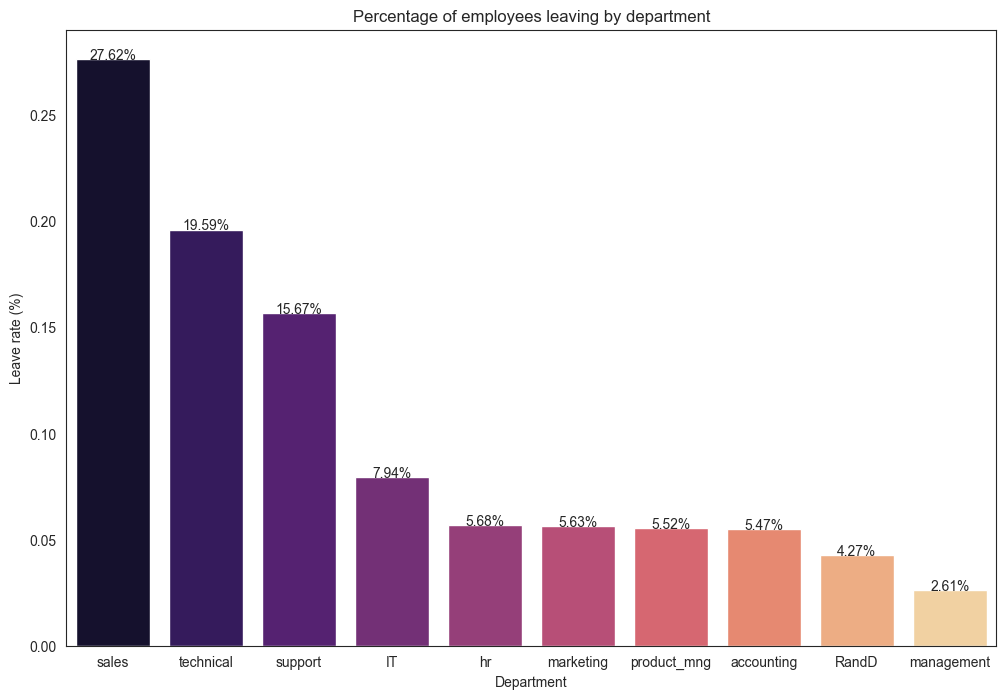

In [384]:
# Find % of employees leaving by each department
leave_rate_dept = df1[df1['left'] == 1]['department'].value_counts(normalize = True)

leave_rate_dept = leave_rate_dept.sort_values(ascending = False)

plt.figure(figsize=(12,8))
sns.barplot(x = leave_rate_dept.index, y = leave_rate_dept.values, palette = 'magma')
plt.xlabel('Department')
plt.ylabel('Leave rate (%)')
plt.title('Percentage of employees leaving by department')

for i, value in enumerate(leave_rate_dept.values):
    plt.text(i, value, f'{value:.2%}', ha = 'center')

plt.show()

Here we can see sales department makes up the most of employees leaving (27.62%), followed by technical and support departments

We can look further into these departments, to see how many monthly hours they work, satisfaction, projects and salary

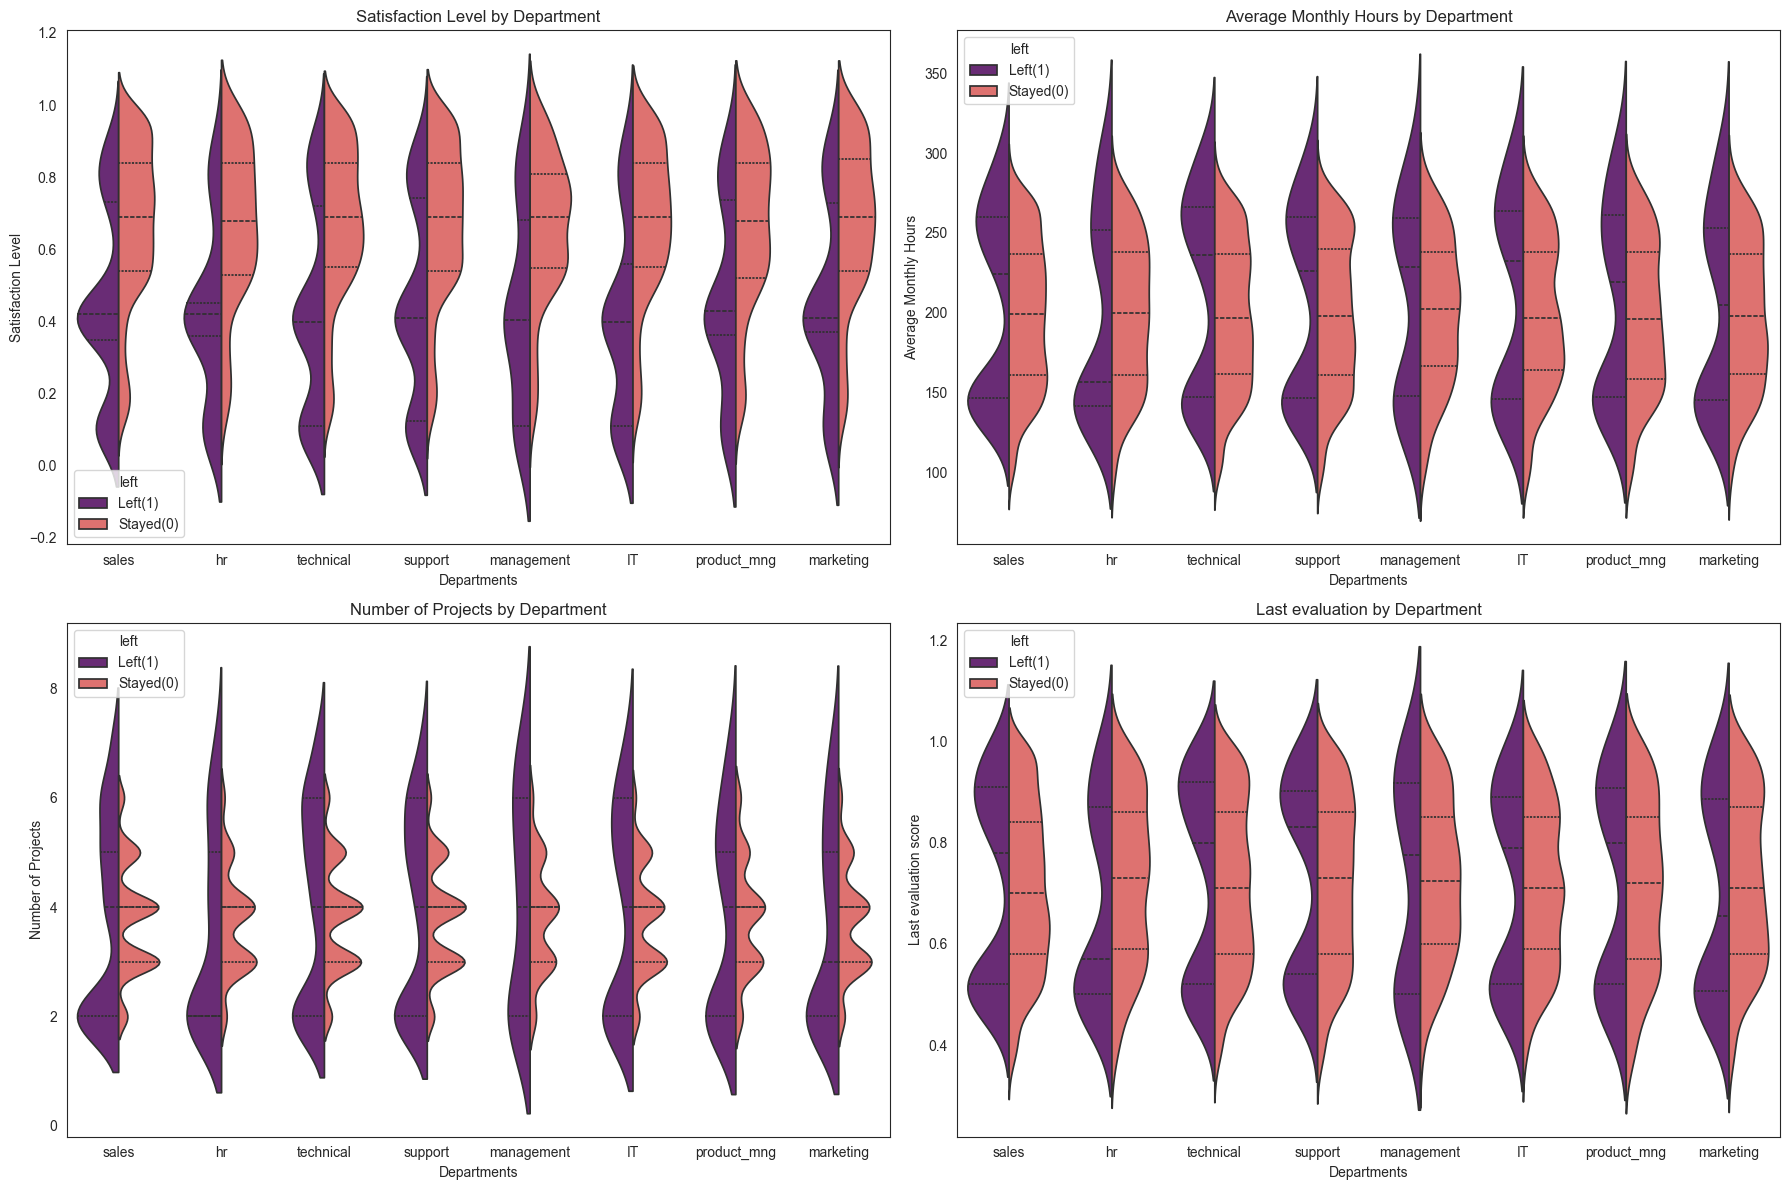

In [401]:
departments = ['sales', 'technical', 'support', 'IT', 'hr', 'marketing', 'product_mng', 'account', ' RandD', 'management']
department_data = df1[df1['department'].isin(departments)]

department_data['left'] = department_data['left'].map({0: 'Stayed(0)', 1: 'Left(1)'})



plt.figure(figsize=(18, 12))

# Satisfaction level
plt.subplot(2, 2, 1)
sns.violinplot(x='department', y='satisfaction_level', hue='left', data=department_data, split=True, inner = 'quartile', palette='magma')
plt.title('Satisfaction Level by Department')
plt.ylabel('Satisfaction Level')
plt.xlabel('Departments')


# Average monthly hours
plt.subplot(2, 2, 2)
sns.violinplot(x='department', y='average_monthly_hours', hue='left', data=department_data, split=True, inner = 'quartile', palette='magma')
plt.title('Average Monthly Hours by Department')
plt.ylabel('Average Monthly Hours')
plt.xlabel('Departments')


# Number of projects
plt.subplot(2, 2, 3)
sns.violinplot(x='department', y='number_project', hue='left', data=department_data, split=True, inner = 'quartile', palette='magma')
plt.title('Number of Projects by Department')
plt.ylabel('Number of Projects')
plt.xlabel('Departments')

# Evaluation score
plt.subplot(2, 2, 4)
sns.violinplot(x='department', y='last_evaluation', hue='left', data=department_data, split=True, inner = 'quartile', palette='magma')
plt.title('Last evaluation by Department')
plt.ylabel('Last evaluation score')
plt.xlabel('Departments')


plt.tight_layout()
plt.show()

# 3. Models

- I will form a Randomforest and XGboost model

## Random Forest

Feature engineering


In [272]:
df_rf = df1.copy()


In [273]:
# Get dummy variables for departments
df_rf = pd.get_dummies(df_rf, columns = ['department'], drop_first = True)


In [274]:

# Encode 'salary'
salary_encode = {'low' : 0, 'medium' : 1, 'high' : 2}
df_rf['salary'] = df_rf['salary'].map(salary_encode)

In [275]:
exclude_cols = ['satisfaction_level', 'last_evaluation']
df_rf[df_rf.columns.difference(exclude_cols)] = df_rf[df_rf.columns.difference(exclude_cols)].astype(int)


In [276]:
df_rf.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  \
0       3              0     1                      0       0   
1       6              0     1                      0       1   
2       4              0     1                      0       1   
3       5              0     1                      0       0   
4       3              0     1                      0       0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

Data splitting

In [280]:
# Define y (target) variable
y = df_rf['left']

# Define predictor variables
X = df_rf.copy()
X = X.drop("left", axis = 1)

# Split into training annd test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y, random_state = 42)

In [282]:

rf = RandomForestClassifier(random_state = 42)

cv_params = {'max_depth': [2,3,4,5, None],   # set hyperparemeters and values
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']  # Metrics model will capture

rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'f1') # Start GridSearch


In [390]:
%%time
rf_cv.fit(X_train, y_train)  # fit model to training data


CPU times: total: 9min 50s
Wall time: 9min 53s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [284]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 75}

In [285]:
rf_cv.best_score_

np.float64(0.9481728911568847)

We have achieved a F1-score of 0.9467, using the best performing Random Forest model with the hyperparameters provided

In [294]:
best_rf = RandomForestClassifier(max_depth= None, 
                                max_features=4,
                                min_samples_leaf=1, 
                                min_samples_split=4, 
                                n_estimators=75,
                                random_state=42)

# Fit the model to the training data
best_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf.predict(X_test)

In [297]:
def make_results(model_name, model, X_test, y_test):
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Create table of results
    table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'ROC AUC': [roc_auc]
    })

    return table


In [300]:
results_table = make_results("Random Forest CV", best_rf, X_test, y_test)
results_table



Model        F1    Recall  Precision  Accuracy   ROC AUC
0  Random Forest CV  0.954113  0.922948   0.987455   0.98527  0.980782

**F1 Score (0.954113):**
- The F1 score is a harmonic mean of precision and recall. An F1 score of approximately 0.954113 signifies a high balance between precision and recall. This is excellent, as it indicates that the model performs very well in both identifying employees who will leave and avoiding incorrect predictions.


**Recall (0.922948):**

- Recall measures the proportion of actual positives (employees who will leave) that were correctly identified by the model. A recall of 0.923 means the model correctly identifies about 92.3% of the employees who will leave. This is strong and indicates that your model is effective at capturing most of the employees who are likely to leave.

**Precision (0.987455):**

- Precision measures the proportion of predicted positives (employees predicted to leave) that were actually positive. A precision of 0.987 means that when your model predicts an employee will leave, there is a 98.7% chance that the prediction is correct. This is very high, indicating the model rarely predicts employees will leave when they don't.

**Accuracy (0.98527):**

- Accuracy is the overall proportion of correct predictions (both true positives and true negatives) among all predictions. An accuracy of 0.985 means that 98.5% of the total predictions are correct. This reflects strong overall performance but can sometimes be less informative in cases of class imbalance compared to metrics like F1 score.

**AUC ROC (0.98072)**
- An AUC score close to 1.0 indicates excellent model performance. In your case, an AUC score of 0.980782 is very high, suggesting that your model has an excellent ability to distinguish between the two classes (employees who will leave vs. employees who will stay).

**Confusion matrix to visualise results**

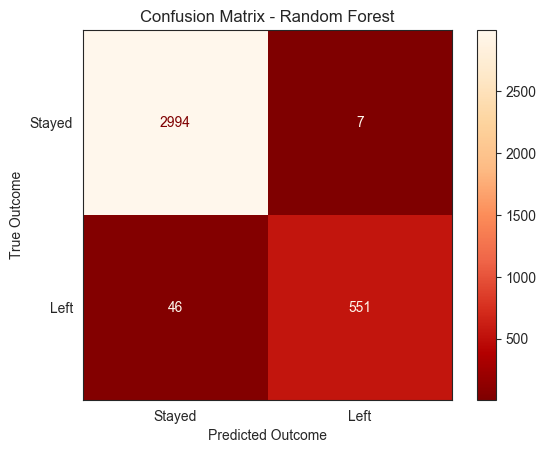

In [351]:
y_pred_rf = best_rf.predict(X_test)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Stayed", "Left"])
disp_rf.plot(cmap='OrRd_r', values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Outcome')
plt.ylabel('True Outcome')
plt.show()

- True Negatives (2994) : Employees who actually stayed and were correctly predicted to stay through the model

- True positives (551) : Employees who actually left the company and were correctly prediced to leave through this model

- False Positives (46) : Employees who stayed but where incorecttly prediced as leaving by the model

- False Negatives (7) : Employees who left the company but where incorrectly prediced as staying by the model

**Find the feature importance of Random Forest Model**

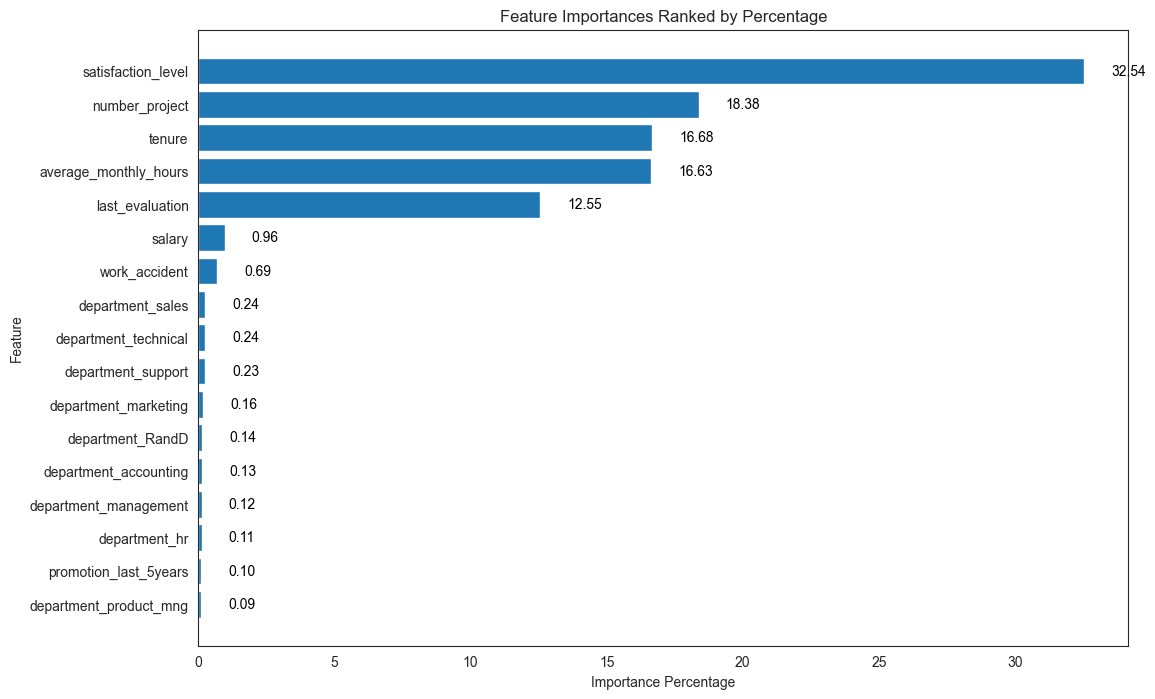

In [327]:
importance_rf = best_rf.feature_importances_

importance_rf = pd.DataFrame({'Feature' : X.columns, 'Importance' : importance_rf})

# Sort by descending importance
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

# Calculate the total sum of importances
total_importance = importance_rf['Importance'].sum()

# % Importance
importance_rf['Importance(%)'] = (importance_rf['Importance'] / total_importance) * 100

plt.figure(figsize=(12, 8))
plt.barh(importance_rf['Feature'], importance_rf['Importance(%)'])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.title('Feature Importances Ranked by Percentage')
plt.gca().invert_yaxis()


for i, v in enumerate(importance_rf['Importance(%)']):
    plt.text(v + 1, i, f'{v:.2f}', color='black', ha='left', va='center')

plt.show()

This random forest shows the most significant predictor of an employee leaving is "satisfaction_level". Contributing 32.54% of the overall importance. Showing the importance of an employee being satisfied within a job to ensure they stay.

"number_project" , "tenure",  "average_monthly salary" and "last_evaluation" also play a good role in predicting if an employee leaves. Coming in at 18.35%, 16.68%, 16.63% and 12.55% respectively.

- We uncovered some of these features importance in our anaylsis prior, stating that satisfaction level, number of projects and average monthly salary will be the main facters in contributing to employees leaving, with satisfaction level being the main impact. But surprisingly tenure seems to also play a decent role according to this model.

## XGBoost

In [328]:
df_xg = df_rf.copy()

In [329]:
df_xg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  \
0       3              0     1                      0       0   
1       6              0     1                      0       1   
2       4              0     1                      0       1   
3       5              0     1                      0       0   
4       3              0     1                      0       0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

In [330]:
# Form XGBoost model
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [403]:
%%time

# Fit the XGBoost model to the training data
xgb_cv.fit(X_train, y_train)

CPU times: total: 7min 10s
Wall time: 1min 6s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [334]:
best_xgb_estimator = xgb_cv.best_estimator_

In [338]:
# Make the predictions on the test set
y_pred_xgb = best_xgb_estimator.predict(X_test)

In [339]:
# See best hyperparameters
print(xgb_cv.best_params_)

{'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 75}


In [357]:
best_xgb = XGBClassifier(max_depth=8, 
                         learning_rate=0.1,
                         min_child_weight=1, 
                         n_estimators=75,
                         random_state=42)

# Fit the model to the training data
best_xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = best_xgb.predict(X_test)

In [358]:
def make_results_xgb(model_name, model, X_test, y_test):
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Create table of results
    table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'ROC AUC': [roc_auc]
    })

    return table

In [359]:
# Create xgb model results table
xgb_cv_results = make_results_xgb('XGBoost CV', xgb_cv, X_test, y_test)
xgb_cv_results

Model       F1    Recall  Precision  Accuracy   ROC AUC
0  XGBoost CV  0.95435  0.927973    0.98227   0.98527  0.986316

In [361]:
model_results = pd.concat([results_table, xgb_cv_results ])
model_results

Model        F1    Recall  Precision  Accuracy   ROC AUC
0  Random Forest CV  0.954113  0.922948   0.987455   0.98527  0.980782
0        XGBoost CV  0.954350  0.927973   0.982270   0.98527  0.986316

**F1 Score**:

- XGBoost Performs slightly better, indicating marginally better balance between precision and recall. 

**Recall:**
- XGBoost performs better, meaning it identifies slightly more true positives (employees likely to leave).

**Precision:**
- Random Forest has a slight edge, meaning fewer false positives, though the difference is minimal.

**Accuracy:**
- 	Equal performance, showing both models correctly classify the same percentage of cases overall.

**ROC AUC:**
- XGBoost performs better, indicating it has a stronger ability to distinguish between classes (employees who will leave vs. stay).

**Confusion Matrix**

In [404]:
def conf_matrix_plot(model, x_data, y_data):

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = model.classes_)
    
    disp.plot(cmap = 'OrRd_r')
    plt.xlabel('Predicted outcome')
    plt.ylabel('True outcome')
    plt.title('Confusion Matrix - XGBoosting')
    plt.show()

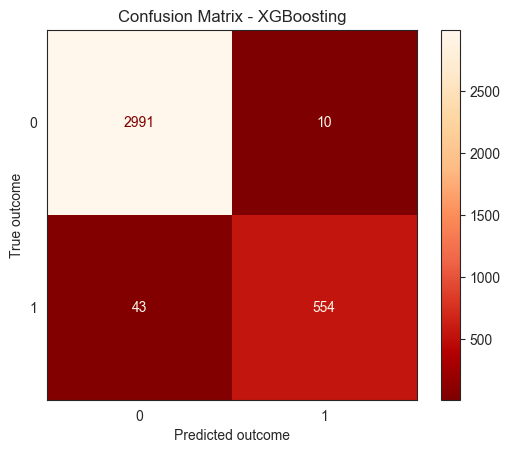

In [405]:
conf_matrix_plot(xgb_cv, X_test, y_test)

We can see the trade offs here, XGBoost sacrifices True negatives (2991) for more True Positives (554), and has less False positives (43) for more False negatives (10) 



However we can further improve our XGBoost model, we can add more hyperparameters such as : subsample, gamma, colsample_bytree. 

- This can further find better combinations for our model that will maximise its performence further

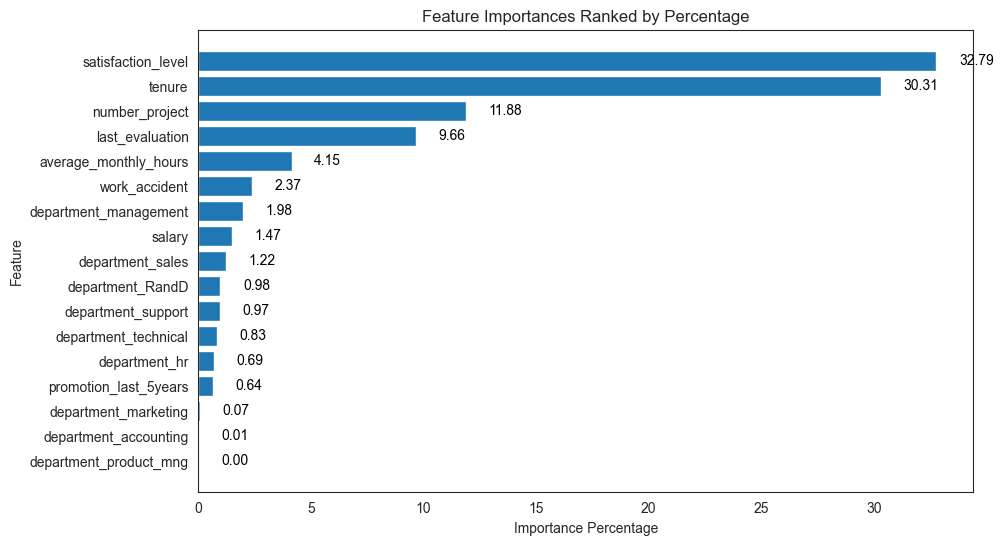

In [368]:
# Get feature importance from XGBoost model and form a % of each feature
importance_xgb = best_xgb_estimator.feature_importances_

importance_xgb = pd.DataFrame({'Feature': X.columns, 'Importance': importance_xgb})

importance_xgb = importance_xgb.sort_values(by='Importance')

total_importance_xgb = importance_xgb['Importance'].sum()

importance_xgb['Importance(%)'] = (importance_xgb['Importance'] / total_importance_xgb) * 100


# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_xgb['Feature'], importance_xgb['Importance(%)'])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.title('Feature Importances Ranked by Percentage')

# Add the numbers by the side of the bars
for i, v in enumerate(importance_xgb['Importance(%)']):
    plt.text(v + 1, i, f'{v:.2f}', color='black', ha='left', va='center')

plt.show()

Again we see "satisfaction_level" has the highest importancd % for the model, being marginally higher then in the randomforest model at 32.79.

However now "tenure" has a much larger importance at 30% now as well, followed by "number_project" at 11.88%, "last_evaluation" at 9.66%, and "average_monthly_hours" at 4.15%.
- Hence we still have the same 5 features with satisfaction level being the highest, but the remainding features are in difference order now.


For Average monthly Hours
- F Score of 738: Indicates that "average_montly_hours" contributes significantly to improving the model. This is a substantial value, suggesting that the feature plays an important role in the model's predictions.
- % Importance of 4.15%: Shows that "average_montly_hours" contributes 4.15% of the total feature importance. This provides a relative measure of how much the feature contributes compared to others.

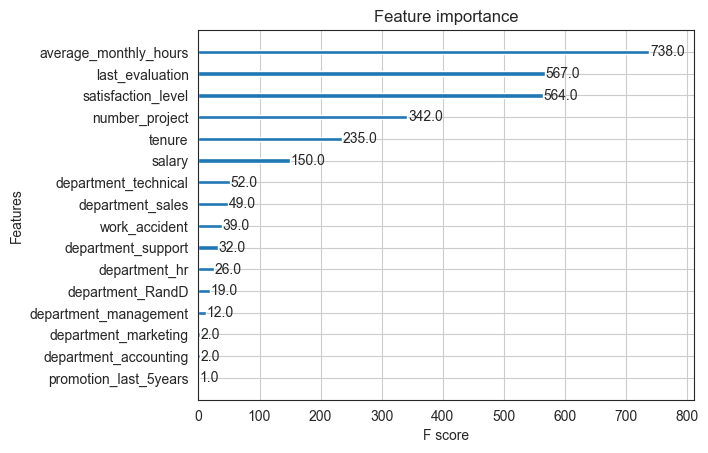

In [369]:
plot_importance(xgb_cv.best_estimator_);

The F score provides a quantitative measure of feature importance, helping  understand which features are most influential in the model.

- IT Measures the contribution of features based on their gain, coverage, and weight, ranking them by their importance.
- Higher F scores indicate more important features that have a greater impact on improving the model's performance



Here we see "average_monthly_hours" is first by a large amount (738) followed by "last_evaluation" at 567 and "satisfaction_level" at 564.

For Average monthly Hours
- F Score of 738: Indicates that "average_montly_hours" contributes significantly to improving the model. This is a substantial value, suggesting that the feature plays an important role in the model's predictions.
- % Importance of 4.15%: Shows that "average_montly_hours" contributes 4.15% of the total feature importance. This provides a relative measure of how much the feature contributes compared to others.

In practice, a feature with a high F score but lower % importance might be contributing significantly to specific aspects of the model's decision-making but is not the most dominant feature when compared to the entire set of features.

# 4. Key Insights

Although the Random Forest and XGBoost models are both high-performing, they use different underlying algorithms. Random Forest is an ensemble of decision trees using bagging, while XGBoost is based on gradient boosting. This difference in approach can lead to slightly different predictions for individual cases.
- Nevertheless both models performed extremely well, with strong predictive performence. Obtaining high, F1, precision, accuracy, recall and AUC-ROC scores

Overall through our EDA and Model formation we saw that there are key factors that influece the attrition ; employee satisfaction, number of projects, last evaluations, average monthly hours and tenure

There is a strong correlation between employees working long hours/ doing alot of projects having lower satisfaction levels leading to them leaving the company
- Through our models and EDA, we can conclude that employee satisfaction is the key feature in determing whether an employee leaves or stays


**Business recommendations**

1. A focus on maintaining high employee satisfaction will lead to a fall in employees leaving. This can be done improving employee engagement, rewarding employees, doing monthly anonmyous surveys on work satisfaction and workload, fostering positive working enviroment.

2. Furthermore there is the notion of improving work life balance, ensuring no one reaches around 300 hours per month as mostly all employees leave when working this amount of hours. Similiary no employee should work 7 projects, as at 7 projects every employee leaves.

3. Greater opportunties for promotion or salary raises, as we found higher salary employees are less likely to leave even when work up to 300 hours a week compared to medium and low salary employees




**Model improvement**
- Both models can be improved further through including more hyperparameters and more selection for Gridsearch to find the optimal hyperparemters. However this comes at the cost of a longer run time.

- Model could also be improved by improving the class imbalance, this can be done by having better sampling techniques

# Conclusion



This project was dedicated to analyzing and modeling employee attrition data to uncover key factors that influence employee turnover and to develop actionable strategies for improving retention rates. Through comprehensive data exploration and analysis, we identified several critical variables that  impacted attrition rates, we started to find these trends especially in the 3D plots, noticing patterns between variables such as satisfaction levels, working hours and number of projects. 


I then used 2 predictive modeling techniques,Random Forest, and XGBoost,models capable of predicting employee turnover. Each model offered unique insights into the underlying drivers of attrition, allowing us to understand the factors that contribute to employee dissatisfaction and departure. Both models performed very well, obtaining high, F1, precision, accuracy, recall and AUC-ROC scores. Nevertheless these models can still be improved on to increase its performence through introducing more hyperparameters.

Based on these insights, i reccomended practical examples aimed at reducing employee turnover and enhancing retention. These recommendations include keeping a close eye on customer satisfaction through various methods such as surveys, compensation, greater employee engangement. As well as improving work life balance and greater opportunites within the company to address specific factors identified as key drivers of attrition.

Overall, this project not only offers a detailed understanding of the factors influencing employee attrition but also lays the groundwork for ongoing efforts to improve employee retention and foster a more stable and satisfied workforce.